# Project: Investigate a Dataset - No show medical appointment in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The goal of this document is to investigate a dataset containing the presence or not of a patient to a medical appointment in Brazil.

The primary source of the dataset was Kaggle ([link](https://www.kaggle.com/joniarroba/noshowappointments)). The exact link of the dataset will be given below.

In [1]:
#Import python libraries
import sys
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Check of the versions of Python and the different modules used to ease reproductibility.

In [2]:
print("Version of Python: %s"%(sys.version))
print("Version of sys: sys is a python embedded module. Please refer to the python's version.")
print("Version of datetime: datetime is a python embedded module. Please refer to the python's version.")
print("Version of pandas: %s"%(pd.__version__))
print("Version of matplotlib :%s"%(matplotlib.__version__))
print("Version of seaborn: %s"%(sns.__version__))

Version of Python: 2.7.13 |Anaconda custom (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]
Version of sys: sys is a python embedded module. Please refer to the python's version.
Version of datetime: datetime is a python embedded module. Please refer to the python's version.
Version of pandas: 0.19.2
Version of matplotlib :2.0.0
Version of seaborn: 0.7.1


<a id='wrangling'></a>
## Data Wrangling

<a id='general_properties'></a>
### General Properties

The dataset used for this analysis was originated from this place: [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv)

In [3]:
# Import the dataset
noshowapp_df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

We can now have a first look on the content of the data. Here are the first 5 rows.

In [4]:
noshowapp_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


A list of all columns:

In [5]:
noshowapp_df.columns

Index([u'PatientId', u'AppointmentID', u'Gender', u'ScheduledDay',
       u'AppointmentDay', u'Age', u'Neighbourhood', u'Scholarship',
       u'Hipertension', u'Diabetes', u'Alcoholism', u'Handcap',
       u'SMS_received', u'No-show'],
      dtype='object')

A count of each non null element of each column.

In [6]:
noshowapp_df.count()

PatientId         110527
AppointmentID     110527
Gender            110527
ScheduledDay      110527
AppointmentDay    110527
Age               110527
Neighbourhood     110527
Scholarship       110527
Hipertension      110527
Diabetes          110527
Alcoholism        110527
Handcap           110527
SMS_received      110527
No-show           110527
dtype: int64

We can see that no column constains empty elements. We have 110527 entries in the dataset.

### Data Cleaning

#### Cleaning the Columns

The column named "Hipertension" and "Handcap" seem to be wrongly spelled.

In portugese, hypertension is hipertensao. The error seems to be a wrong translation. We will replace the column name "Hipertension" by "Hypertention".

After research, the word "Handcap" does not exist. In a portugese dictionnary nothing can justify this wording. Here we decided to rename the colunm "Handcap" by "Handicap".

In [7]:
# Rename the column Hipertension and Handcap by the correct wording.
noshowapp_df = noshowapp_df.rename(index=str, columns={"Hipertension": "Hypertension", "Handcap": "Handicap"})

In [8]:
noshowapp_df.columns

Index([u'PatientId', u'AppointmentID', u'Gender', u'ScheduledDay',
       u'AppointmentDay', u'Age', u'Neighbourhood', u'Scholarship',
       u'Hypertension', u'Diabetes', u'Alcoholism', u'Handicap',
       u'SMS_received', u'No-show'],
      dtype='object')

Now the columns are less confusing.

#### Cleaning the Rows

We will review each rows to see if they contains strange values.

##### PatientId

Check of the limit of the patient ID.

In [9]:
noshowapp_df['PatientId'].min()

39217.844389999998

In [10]:
noshowapp_df['PatientId'].max()

999981631772427.0

The Patient IDs are quite huge and it seems to have a problem in the import of the file. After check in the CSV file, some patient ID are noted in an exponential notation.

We have to multiply the wrong IDs by 10E5.

Let find the faulty IDs and correct the values.

In [11]:
noshowapp_df.loc[noshowapp_df['PatientId'] < 5000000]['PatientId']

3950       93779.52927
73228     537615.28476
73303     141724.16655
100517     39217.84439
105430     43741.75652
Name: PatientId, dtype: float64

By trying some limits value we find those 5 values which have a strange number.

Before correct the value, we have to check if the values does not exists in the table. If it is the case, we will have to analyse the duplicates to verify if it is realy the same person or not.

In [12]:
def correctPatientID(patientID):
    '''
    Check if a patient ID is present is the database with the ID*10E5.
    If no, correct the row in the dataset.
    If yes, display a message for further investigation
    '''
    newPatientID = float(int(patientID*10E5))
    result = noshowapp_df.loc[noshowapp_df['PatientId'] == newPatientID]
    if result.shape[0] > 0:
        print("Match found for patientID %.1f"%(patientID))
        print(result)
        print("----------------------------------------")
    else:
        print("No match found for patient ID %.1f"%(patientID))
        print("Correct the value. PatientID %.1f becomes %.1f"%(patientID, newPatientID))
        noshowapp_df.loc[(noshowapp_df['PatientId'] == patientID),(['PatientId'])] = newPatientID
        print("")

patientIDtoCheck = noshowapp_df.loc[noshowapp_df['PatientId'] < 5000000]['PatientId']
res = patientIDtoCheck.apply(correctPatientID)

No match found for patient ID 93779.5
Correct the value. PatientID 93779.5 becomes 93779529270.0

No match found for patient ID 537615.3
Correct the value. PatientID 537615.3 becomes 537615284760.0

No match found for patient ID 141724.2
Correct the value. PatientID 141724.2 becomes 141724166550.0

No match found for patient ID 39217.8
Correct the value. PatientID 39217.8 becomes 39217844390.0

No match found for patient ID 43741.8
Correct the value. PatientID 43741.8 becomes 43741756519.0



By luck no duplicates were found and all patient IDs are now corrected.
Let check if it is really the case:

In [13]:
noshowapp_df.loc[noshowapp_df['PatientId'] < 5000000]['PatientId']

Series([], Name: PatientId, dtype: float64)

The result is an empty serie. The IDs are now corrected.

How many patients are registered in the dataset. some patients can have more than one appointment.

In [14]:
len(noshowapp_df['PatientId'].unique())

62299

There are 62299 unique patients are in the dataset.

#### AppointmentID

Check the limit of the data contains in column "AppointmentID"

In [15]:
noshowapp_df['AppointmentID'].min()

5030230

In [16]:
noshowapp_df['AppointmentID'].max()

5790484

For this column the limits make sense.

Each ID should be unique. Let check that.

In [17]:
len(noshowapp_df['AppointmentID'].unique())

110527

All Appointment IDs are unique. This row seems to be clean.

##### Gender

Which gender do we have in this column. Only Male and Female?

In [18]:
noshowapp_df['Gender'].unique()

array(['F', 'M'], dtype=object)

No creativity here. We have only male and female.

##### Scheduled day

This column indicate when the patient call for his/her appointment.

Let have a look on the format:

In [19]:
noshowapp_df['ScheduledDay'].head()

0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
3    2016-04-29T17:29:31Z
4    2016-04-29T16:07:23Z
Name: ScheduledDay, dtype: object

The format is a string and should be converted.

In [20]:
def convertDate(str):
    return datetime.datetime.strptime(str, '%Y-%m-%dT%H:%M:%SZ')

noshowapp_df['ScheduledDay'] = noshowapp_df['ScheduledDay'].apply(convertDate)

Let see what we have for data recorded.

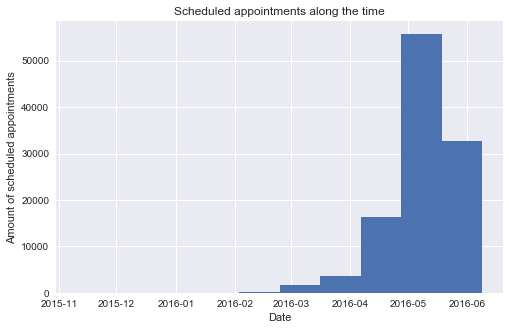

In [21]:
plt.rcParams['figure.figsize'] = 8, 5
noshowapp_df['ScheduledDay'].hist()
plt.title("Scheduled appointments along the time")
plt.xlabel("Date")
plt.ylabel("Amount of scheduled appointments")

The repartition of the data is quite strange. It seems that data were collected more or less during 2 or 3 month. A look on the appointment day will give us more details.

In all case this will exclude an analysis of a potential seasonal variations.

##### Appointment Day

This column should be similarly coded than the scheduled day. Let see.

In [22]:
noshowapp_df['AppointmentDay'].head()

0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
3    2016-04-29T00:00:00Z
4    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object

Here the hour seems to be zero. We can use the same function to convert the date than for scheculed day.

In [23]:
noshowapp_df['AppointmentDay'] = noshowapp_df['AppointmentDay'].apply(convertDate)

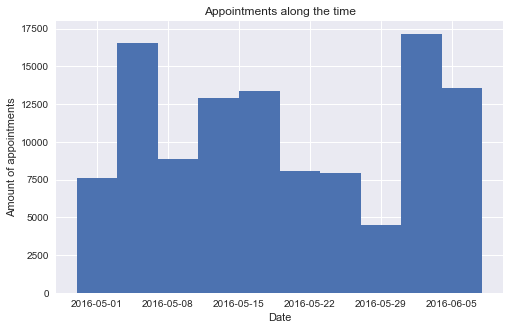

In [24]:
plt.rcParams['figure.figsize'] = 8, 5
noshowapp_df['AppointmentDay'].hist()
plt.title("Appointments along the time")
plt.xlabel("Date")
plt.ylabel("Amount of appointments")

The appointment day's values reveal the reason of the repartition of the schedule day's values. The dataset if just for one month. Due to the fact that some people set their appoinement in advance this explains the shape of the schedule days's graph.

<a id='Age'></a>
##### Age

Check the limit of the ages in the dataset.

In [25]:
noshowapp_df['Age'].min()

-1

In [26]:
noshowapp_df['Age'].max()

115

The maximum is quite high but realistic. The minimum value is not valid. How many such values we have and for which entries?

In [27]:
noshowapp_df[noshowapp_df['Age'] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


Only one entrie is wrong. We can correct it by replacing the -1 value by the median age of the women from ROMÃO.

In [28]:
ageSubstitute = int(round(noshowapp_df[(noshowapp_df['Age'] >= 0) \
                                       & (noshowapp_df['Neighbourhood'] == 'ROMÃO') \
                                       & (noshowapp_df['Gender'] == 'F')]['Age'].median()))
noshowapp_df = noshowapp_df.replace({'Age':{-1 : ageSubstitute}})

In [29]:
noshowapp_df.iloc[99832]['Age']

33

In [30]:
noshowapp_df[noshowapp_df['Age'] > 100]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
58014,9.762948e+14,5651757,F,2016-05-03 09:14:53,2016-05-03,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31 10:19:49,2016-06-02,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,No


Only a few visits for people aged more than 100 years. 4 differents people had some appointments.

Now there is no more wrong value in the Age column.

What is the repartition of the ages?

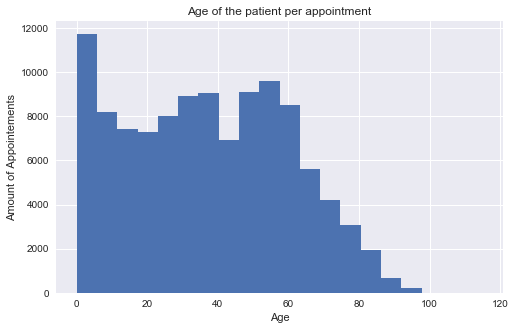

In [31]:
plt.rcParams['figure.figsize'] = 8, 5
noshowapp_df['Age'].hist(bins=20)
plt.title("Age of the patient per appointment")
plt.xlabel("Age")
plt.ylabel("Amount of Appointements")

Here nothing suspect. We see a lot of appointment are done for very young children.

##### Neighbourhood

The following neighbourhoods are present in the dataset:

In [32]:
# Due to special caracters, the standard export does not work well. A print commant solve this issue.
for i in noshowapp_df['Neighbourhood'].unique():
    print(i)

JARDIM DA PENHA
MATA DA PRAIA
PONTAL DE CAMBURI
REPÚBLICA
GOIABEIRAS
ANDORINHAS
CONQUISTA
NOVA PALESTINA
DA PENHA
TABUAZEIRO
BENTO FERREIRA
SÃO PEDRO
SANTA MARTHA
SÃO CRISTÓVÃO
MARUÍPE
GRANDE VITÓRIA
SÃO BENEDITO
ILHA DAS CAIEIRAS
SANTO ANDRÉ
SOLON BORGES
BONFIM
JARDIM CAMBURI
MARIA ORTIZ
JABOUR
ANTÔNIO HONÓRIO
RESISTÊNCIA
ILHA DE SANTA MARIA
JUCUTUQUARA
MONTE BELO
MÁRIO CYPRESTE
SANTO ANTÔNIO
BELA VISTA
PRAIA DO SUÁ
SANTA HELENA
ITARARÉ
INHANGUETÁ
UNIVERSITÁRIO
SÃO JOSÉ
REDENÇÃO
SANTA CLARA
CENTRO
PARQUE MOSCOSO
DO MOSCOSO
SANTOS DUMONT
CARATOÍRA
ARIOVALDO FAVALESSA
ILHA DO FRADE
GURIGICA
JOANA D´ARC
CONSOLAÇÃO
PRAIA DO CANTO
BOA VISTA
MORADA DE CAMBURI
SANTA LUÍZA
SANTA LÚCIA
BARRO VERMELHO
ESTRELINHA
FORTE SÃO JOÃO
FONTE GRANDE
ENSEADA DO SUÁ
SANTOS REIS
PIEDADE
JESUS DE NAZARETH
SANTA TEREZA
CRUZAMENTO
ILHA DO PRÍNCIPE
ROMÃO
COMDUSA
SANTA CECÍLIA
VILA RUBIM
DE LOURDES
DO QUADRO
DO CABRAL
HORTO
SEGURANÇA DO LAR
ILHA DO BOI
FRADINHOS
NAZARETH
AEROPORTO
ILHAS OCEÂNICAS DE TRINDADE
PAR

All seems to be OK. We can notice a Santa Lucia and Santa Luzia. After a check, those two areas exist and are different in Brazil. 

No corrections are needed here. 

##### Scholarship

The column scholarship indicate if the person is enrolled in Brasilian welfare program Bolsa Família. The value should be 0 or 1.

In [33]:
noshowapp_df['Scholarship'].unique()

array([0, 1], dtype=int64)

Only 0 and 1 are present.

No corrections are needed here.

##### Hypertension, Diabetes, Alcoholism and Handicap

Those columns indicates some information about some pathologies of the patient.
The column sms reveceived indicates if some messages were sent to the patient or not. It is also a binary information.

All columns are independent and should be filled by 0 or 1.

In [34]:
# Instead of check the unique values. Let try something different.

ColumnsToCheck = ['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received']
valueToCheck = [0,1]

def checkValue(entrie):
    if entrie not in valueToCheck:
        return -1
    return 0

def checkValueInColumn(col):
    result = noshowapp_df[col].apply(checkValue)
    if  -1 in result:
        print("Error found in column %s (value out of boundary). Please check it."%(col))
    else:
        print("Column %s OK"%(col))

for col in ColumnsToCheck:
    checkValueInColumn(col)

Column Hypertension OK
Column Diabetes OK
Column Alcoholism OK
Column Handicap OK
Column SMS_received OK


All columns contain only 0 or 1. 

No correction are needed here.

##### No-show

The column No-show indicate if a patient was present for his/her appointment or not.
Instead of 0 and 1 the value here are:
- yes: if the patient was not present
- no: if the patient was present

In [35]:
# We can reuse the function checkValueInColumn to check this one
valueToCheck = ['Yes', 'No']

checkValueInColumn('No-show')

Column No-show OK


The column No-show seems to be clean.

No corrections are needed.

### Conclusion of the data cleaning

The overall dataset is relatively clean. No big corrections were done on it. 

Here are the first 5 entries of the cleaned dataset.

In [36]:
noshowapp_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Which factors are correlated to the no show of the patient?)

First have a look on the No-show column.

In [37]:
noshowapp_df[noshowapp_df['No-show'] == 'Yes']['No-show'].count() / float(noshowapp_df['No-show'].count()) * 100

20.193255946510806

There is a little bit more than 20% of the appointment were the patient did not come. That is a lot.

#### Do the gender has a role in the no-show?

In [38]:
gender_no_show = noshowapp_df.groupby(['Gender', 'No-show'])['AppointmentID'].count()

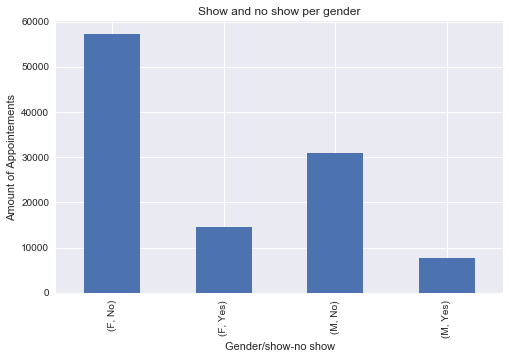

In [39]:
plt.rcParams['figure.figsize'] = 8, 5
gender_no_show.plot.bar()
plt.title("Show and no show per gender")
plt.xlabel("Gender/show-no show")
plt.ylabel("Amount of Appointements")

More women have an appointment. The proportion seems to be similar.
We should have a look in detail by normalize the values:

In [40]:
for i in gender_no_show.index.levels[0]:
    gender_no_show[i] = gender_no_show[i]/gender_no_show[i].sum()*100
    
gender_no_show

Gender  No-show
F       No         79
        Yes        20
M       No         80
        Yes        19
Name: AppointmentID, dtype: int64

The proportion is quite similar. 80% patient came 20% did not, indepently of the gender.

#### Is the Age a factor?

In [41]:
age_no_show = noshowapp_df[noshowapp_df['No-show'] == 'Yes'].groupby('Age')['AppointmentID'].count() / noshowapp_df.groupby('Age')['AppointmentID'].count()
age_no_show = age_no_show.fillna(0)

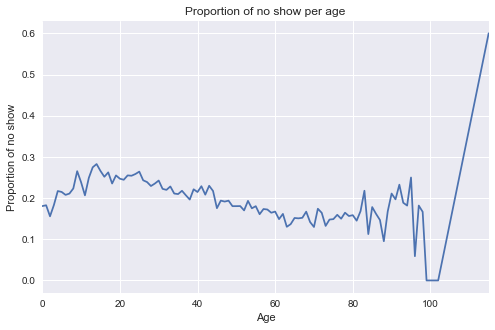

In [42]:
plt.rcParams['figure.figsize'] = 8, 5
age_no_show.plot()
plt.title("Proportion of no show per age")
plt.xlabel("Age")
plt.ylabel("Proportion of no show")

Young people have tendency to less come than the older ones. Here it is not strongly correlatated.

For people older than 80 the curve show no strog variation. This is due to the few entries for the population.

The last record is a 115 years old patient who miss several appointment. It concerns only one entry. It is  not really relevant. (Please refer to the chapter of the check of the <a href="#age">Age</a>).

#### Are there some patients with a lot of missed appointment?

In [43]:
totalNo_show = noshowapp_df[noshowapp_df['No-show'] == 'Yes']['No-show'].count()

In [44]:
no_showPerPatient = noshowapp_df.groupby('PatientId')['No-show'].count().sort_values().values

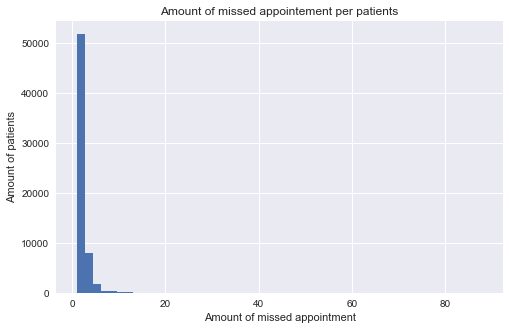

In [45]:
plt.rcParams['figure.figsize'] = 8, 5
plt.hist(no_showPerPatient, bins=50)
plt.title("Amount of missed appointement per patients")
plt.xlabel("Amount of missed appointment")
plt.ylabel("Amount of patients")

Most of patient miss one or two appointment. Only few of them miss more.
The record is 88.

There is no bias in the dataset for this parameter.

In [46]:
no_showPerPatient.max()

88

### Conclusion of the analysis of the possible correlation with the no show of the patients

The gender and the age are not correlated to the no show of the patients. Younger people tend to miss more appointements than the older ones.

In the dataset, there is no little group of patients who can push the no show rate up due to a big amount of missed appointement.

### Research Question 2  (Is alcoholism dependent of the area?)

What is the repartition of the neighbourhood in the dataset?

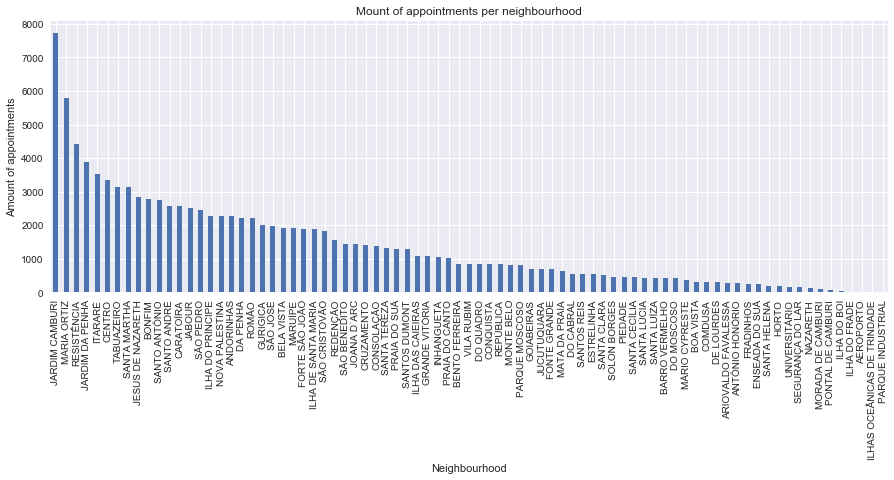

In [47]:
plt.rcParams['figure.figsize'] = 15, 5
noshowapp_df.groupby('Neighbourhood')['AppointmentID'].count().sort_values(ascending=False).plot.bar()
plt.title("Mount of appointments per neighbourhood")
plt.ylabel("Amount of appointments")

As we can expect the repartition is not homogeneous. 

In [48]:
pathologyPerNeighbourhood = noshowapp_df.groupby('Neighbourhood')['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap'].sum()

In [49]:
# Make the sum of each lines
pathologyPerNeighbourhood['Sum'] = pathologyPerNeighbourhood.sum(axis=1)

In [50]:
for col in ['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']:
    pathologyPerNeighbourhood[col] = pathologyPerNeighbourhood[col] / pathologyPerNeighbourhood['Sum'] *100
pathologyPerNeighbourhood.sort_values(by='Sum', ascending=False, inplace=True)

We can make a graph of the different pathology sorted by order of amount of pathologies. This will class the representation per representativity (Neighbourghood with more samples first).

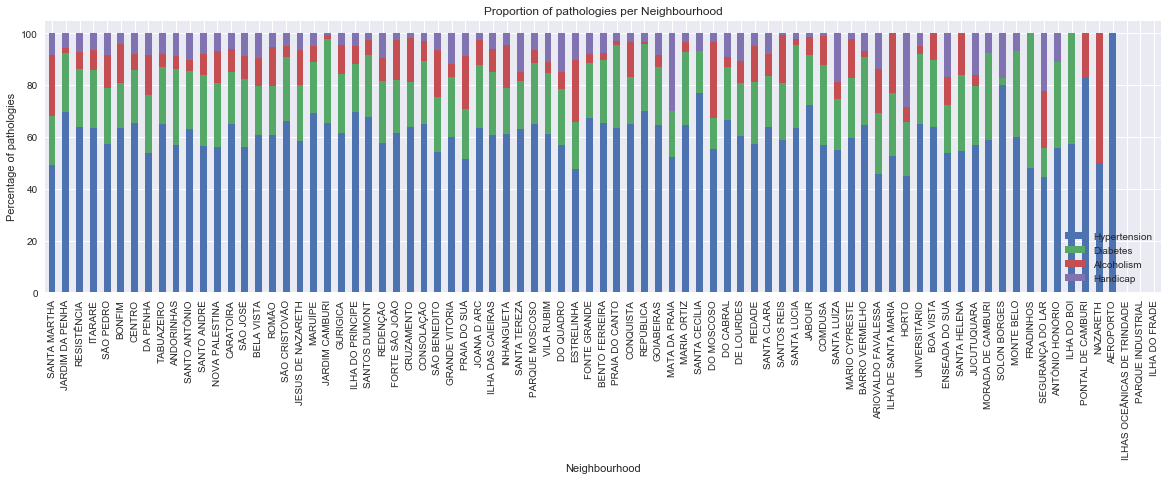

In [51]:
pathologyPerNeighbourhood.drop('Sum', axis=1, inplace=True)
plt.rcParams['figure.figsize'] = 20, 5
pathologyPerNeighbourhood.plot.bar(stacked=True)
plt.title("Proportion of pathologies per Neighbourhood")
plt.ylabel("Percentage of pathologies")

Hypertension is the first pathology in the dataset. Handicap is the less represented. It is strange because handicap covers more trouble than hypertension. This word has to be better defined.

We see that Nazareth have a rate of 50% of alcoholism but the number of samples is very small and this result is not representative.

For some other Neighbourhood the result is more representative. Santa Martha have a rate of alcoholism higher than the other areas. It is also the case for Bonfim, Nova Palestina or Romao.

A deeper analysis is here needed 

### Conclusion of the alcoholism rate per neighbourhood

We found here that the category "Handicap" should be better defined. We found also some area with more alcoholism than the other but a deeper analysis is here needed to find good candidate to launch an action for the prevention of alcoholism.

<a id='conclusions'></a>
## Conclusions

The dataset is quite clean but limited in time (only one month of data). This exclude an seasonal analysis of the variation. Some wordings are also not clear. The category "Handicap" has to be better defined.

The no show parameter was studied and compare to the age and the gender. No correlation was found here. Only a tendency of joung people to be less present. The dataset contains no bias for the no show parameter. No patient influences strongly the result of the anaylsis.

Some place have more cases in Alcoholism than some other. Santa Marta, Bonfim, Nova Palestina and Romao for example. More anaylss are needed here to know the real diffence to the other. The data should be crossed with some economical data in order to find an adequate response to the problem. 